In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
import os

from hparams import hparams, hparams_debug_string
from model.AutoEncoder import AutoEncoder
from model.StarGAN_VC import Generator, Discriminator 
from dataloader import VoiceDataset, ToTensor, RandomCrop
from utils import World


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
log_dir = "./log"
data_dir = "./data"
generator_name ="generator"
discriminator_name ="discriminator"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

In [9]:
generator = Generator()
generator.to(device)
discriminator = Discriminator()
discriminator.to(device)
if os.path.exists(os.path.join(log_dir, generator_name)):
    generator.load_state_dict(torch.load(os.path.join(log_dir, generator_name), map_location=device))
if os.path.exists(os.path.join(log_dir, discriminator_name)):
    discriminator.load_state_dict(torch.load(os.path.join(log_dir, discriminator_name), map_location=device))

In [10]:
dataset = VoiceDataset(root_dir=data_dir, source_limit=hparams.source_limit,
                                           transform=transforms.Compose([
                                               RandomCrop(),
                                               ToTensor(),
                                           ]))
dataloader = DataLoader(dataset, batch_size=hparams.batch_size, shuffle=hparams.shuffle, drop_last=True)

['hiroshiba', 'uemura', 'tanezaki', 'tsuchiya', 'fujitou']
[hiroshiba] mcep loaded.
[uemura] mcep loaded.
[tanezaki] mcep loaded.
[tsuchiya] mcep loaded.
[fujitou] mcep loaded.


2903
torch.Size([1, 35, 128]) tensor(2)
tensor(2)


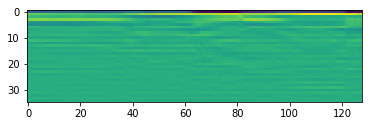

In [11]:
print(len(dataset))
data, label = dataset[np.random.randint(0,2000)]
print(data.shape, label)
plt.imshow(data[0])
print(label)

In [12]:
for i, batch in enumerate(dataloader):
    data, label = batch
    print(data.shape)
    print(data.type())
    print(label)
    onehot = torch.eye(len(dataset.speakers))[label]
    print(onehot)
    break
    

torch.Size([8, 1, 35, 128])
torch.FloatTensor
tensor([2, 2, 4, 1, 2, 2, 2, 2])
tensor([[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]])


In [13]:
optimizer_gen = torch.optim.Adam(generator.parameters(), lr=hparams.learning_rate_gen, weight_decay=hparams.weight_decay)
optimizer_disc = torch.optim.Adam(discriminator.parameters(), lr=hparams.learning_rate_disc, weight_decay=hparams.weight_decay)

In [ ]:
losses_gen = []
losses_disc = []
for epoch in range(hparams.num_epochs):
    
    print("epoch : {}".format(epoch+1))
    
    running_loss = 0.
    for i, batch in enumerate(dataloader):
        
        x_batch, y_batch = batch
        y_t_batch = y_batch[torch.randperm(hparams.batch_size)]
        y_t_batch = y_t_batch.long()
        x_batch, y_batch, y_t_batch = x_batch.to(device), y_batch.to(device), y_t_batch.to(device)
        
        ### Train the discriminator ###
        criterion_disc = nn.BCELoss()
        out_disc_real = discriminator(x_batch, y_t_batch, y_batch)
        out_gen = generator(x_batch, y_batch, y_t_batch)
        out_disc_fake = discriminator(out_gen.detach(), y_batch, y_t_batch)
        
        loss_disc = F.binary_cross_entropy_with_logits(out_disc_fake,torch.zeros_like(out_disc_fake, dtype=torch.float)) + \
                                        F.binary_cross_entropy_with_logits(out_disc_real, torch.ones_like(out_disc_real, dtype=torch.float))
            
        loss_disc.backward()
        optimizer_disc.step()
        optimizer_gen.zero_grad()
        optimizer_disc.zero_grad()
        
        ### Train the Generator ###
        out_gen = generator(x_batch, y_batch, y_t_batch)
        out_disc_fake = discriminator(out_gen, y_batch, y_t_batch)
        
        # Adversarial loss
        loss_adv = F.binary_cross_entropy_with_logits(out_disc_fake, torch.ones_like(out_disc_fake, dtype=torch.float))
        
        # Cycle-consistency loss
        gen_out_cyc = generator(generator(x_batch, y_batch, y_t_batch), y_t_batch, y_batch)
        loss_cyc = F.l1_loss(gen_out_cyc, x_batch)

        # Identity-mapping loss
        gen_out_id = generator(x_batch, y_batch, y_batch)
        loss_id = F.l1_loss(gen_out_id, x_batch)

        if epoch < 100:
            loss_gen = loss_adv + 10 * loss_cyc + 5 * loss_id
        else:
            loss_gen = loss_adv + 10 * loss_cyc 
            
        loss_gen.backward()
        optimizer_gen.step()
        optimizer_gen.zero_grad()
        optimizer_disc.zero_grad()
        
        losses_disc.append(loss_disc.item())
        losses_gen.append(loss_gen.item())
        
    if (epoch+1)%10==0:
        print(epoch+1)
        plt.plot(losses_gen, label="gen")
        plt.plot(losses_disc, label="disc")
        plt.legend()
        plt.savefig(os.path.join(log_dir, "loss.png"))
        plt.show()
        img = x_batch[0].cpu().detach().numpy()
        plt.imshow(img[0])
        plt.savefig(os.path.join(log_dir, "epoch_{}_source.png".format(epoch+1)))
        plt.show()
        img = out_gen[0].cpu().detach().numpy()
        plt.imshow(img[0])
        plt.savefig(os.path.join(log_dir, "epoch_{}_output.png".format(epoch+1)))
        plt.show()
        
        torch.save(generator.state_dict(), os.path.join(log_dir, generator_name))
        torch.save(discriminator.state_dict(), os.path.join(log_dir, discriminator_name))
        


epoch : 1
epoch : 2
epoch : 3


In [ ]:
def load_model(log_dir, model_name):
    model = AutoEncoder()
    if torch.cuda.is_available():
        model.load_state_dict(torch.load(os.path.join(model_dir, model_name), map_location=device))
    return model

In [ ]:
world = World(fs=hparams.fs, fftl=hparams.fftl, shiftms=hparams.shiftms, minf0=hparams.minf0, maxf0=hparams.maxf0)

In [ ]:
x_batch.type(), y_batch.type(), y_t_batch .type()

In [ ]:
np.matmul(np.ones((8, 10, 512)),np.ones((8,512, 1))).shape

In [ ]:
h = torch.ones((3,3))

In [ ]:
h.unsqueeze(2).shape